In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()




In [2]:
data_proxies =  pd.read_sql_query("SELECT * FROM individual_wikipedia", conn)

In [19]:
df = data_proxies[['individual_wikidata_id', 'created_at']]
df = df.dropna()

df['creation_year'] = df['created_at'].apply(lambda x : x[:4])
df['creation_year'] = df['creation_year'].astype(str)
df = df.drop('created_at', axis=1)

In [20]:
df_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)

region_name = 'Low countries'

df_region_fil = df_regions[df_regions['region_name']==region_name]
df_region_fil = df_region_fil[['individual_wikidata_id', 'region_name']].copy()

df_final = pd.merge(df_region_fil, df, on = 'individual_wikidata_id')

df_year = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_year['productive_year'] = df_year['birthyear'] + 35
df_year = df_year[['individual_wikidata_id', 'productive_year']]
df_year = df_year.dropna()
df_year['decade'] = df_year['productive_year'].apply(lambda x: round(x / 10) * 10)

df_final = pd.merge(df_year, df_final, on = 'individual_wikidata_id')


In [27]:
df_group = df_final.groupby(['decade', 'creation_year'])['individual_wikidata_id'].count().reset_index()
df_group['creation_year'] = df_group['creation_year'].astype(str)


,decade,creation_year,individual_wikidata_id
0,640,2006,1
1,640,2007,2
2,640,2011,2
3,640,2020,1
4,960,2006,4
...,...,...,...
1202,1880,2018,74
1203,1880,2019,79
1204,1880,2020,196
1205,1880,2021,84


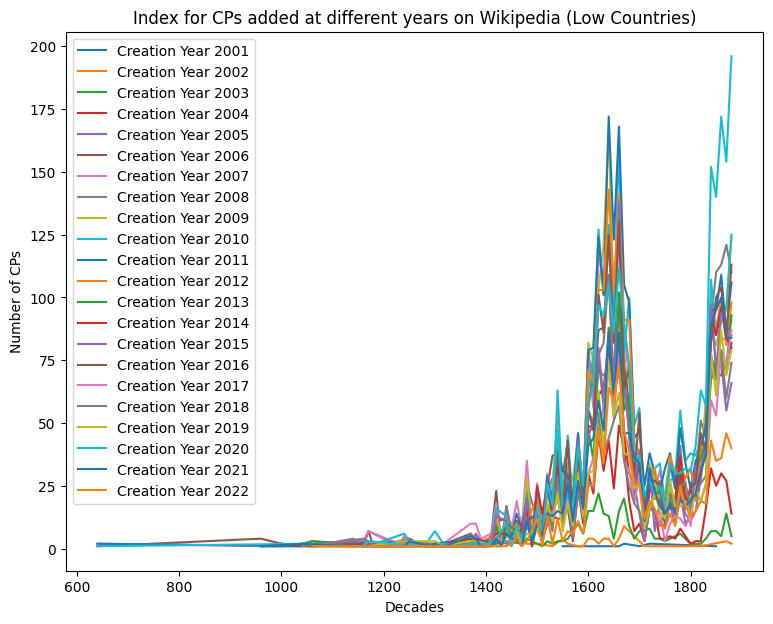

In [34]:
import matplotlib.pyplot as plt


# Plot a line for each creation year category
plt.figure(figsize=(9, 7))

for creation_year, group in df_group.groupby('creation_year'):
    plt.plot(group['decade'], group['individual_wikidata_id'], label=f'Creation Year {creation_year}')

plt.title('Index for CPs added at different years on Wikipedia (Low Countries)')
plt.xlabel('Decades')
plt.ylabel('Number of CPs')
plt.legend()
plt.grid(False)

plt.savefig('figures/wikipedia_stats/evolution_of_creation_year.png', dpi = 200)
plt.show()

In [32]:
df_group

,decade,creation_year,individual_wikidata_id
0,640,2006,1
1,640,2007,2
2,640,2011,2
3,640,2020,1
4,960,2006,4
...,...,...,...
1202,1880,2018,74
1203,1880,2019,79
1204,1880,2020,196
1205,1880,2021,84


In [33]:
df_corr = df_group.pivot(index = "decade", columns = "creation_year", values = 'individual_wikidata_id')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8447044549525561